### Network Revisions

In [1]:
from sqlalchemy import create_engine

# Credentials to database connection
hostname="oss-1.cij9gk1eehyr.us-east-1.rds.amazonaws.com"
dbname="codegov"
uname="admin"
pwd="OSS022323"

# Create SQLAlchemy engine to connect to MySQL Database
engine = create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}"
				.format(host=hostname, db=dbname, user=uname, pw=pwd))

In [2]:
 # Query to fetch all records

import pandas as pd
from sqlalchemy.sql import text
sql = '''
    SELECT * FROM codegov_edge_combos;
'''
with engine.connect().execution_options(autocommit=True) as conn:
    query = conn.execute(text(sql))         
df_combos = pd.DataFrame(query.fetchall())

Remove the Blank and NaN logins

In [3]:
df_combos.head(5)

,slug,login,agency
0,011235813/sept,011235813,Department of Energy
1,18F/domain-scan,,Department of Energy
2,18F/domain-scan,adelevie,Department of Energy
3,18F/domain-scan,afeld,Department of Energy
4,18F/domain-scan,alexbielen,Department of Energy


Add the number of blank logins out of the total logins

In [4]:
# Remove rows where 'login' is NaN or empty
df_combos = df_combos.dropna(subset=['login'])

# Remove empty strings in login
df_combos = df_combos[df_combos['login'] != '']

In [5]:
df_combos.head(5)

,slug,login,agency
0,011235813/sept,011235813,Department of Energy
2,18F/domain-scan,adelevie,Department of Energy
3,18F/domain-scan,afeld,Department of Energy
4,18F/domain-scan,alexbielen,Department of Energy
5,18F/domain-scan,benbalter,Department of Energy


In [6]:
df_test = df_combos[:100]

In [11]:
from itertools import combinations

def get_combinations(group):
    return pd.DataFrame([sorted(e) for e in list(combinations(group['login'].values, 2))], columns=['source', 'target'])

df_check = df_test.groupby(['agency']).apply(get_combinations)

/tmp/ipykernel_4023/829652218.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_check = df_test.groupby(['agency']).apply(get_combinations)


In [15]:
pairs = []

# Group by 'slug'
grouped = df_test.groupby('slug')

for slug, group in grouped:
    if len(group) > 1:
        for source, target in combinations(group['login'], 2):
            pairs.append({'source': source, 'target': target, 'slug': slug, 'agency': group['agency'].iloc[0]})

# Create pairs DataFrame
pairs_df = pd.DataFrame(pairs)

In [17]:
pairs_df.head(5)

,source,target,slug,agency
0,adelevie,afeld,18F/domain-scan,Department of Energy
1,adelevie,alexbielen,18F/domain-scan,Department of Energy
2,adelevie,benbalter,18F/domain-scan,Department of Energy
3,adelevie,blkperl,18F/domain-scan,Department of Energy
4,adelevie,brendansudol,18F/domain-scan,Department of Energy


In [8]:
from itertools import combinations

# Create pairs
pairs = []

# Group by 'slug'
grouped = df_combos.groupby('slug')

for slug, group in grouped:
    if len(group) > 1:
        for source, target in combinations(group['login'], 2):
            pairs.append({'source': source, 'target': target, 'slug': slug, 'agency': group['agency'].iloc[0]})

# Create pairs DataFrame
pairs_df = pd.DataFrame(pairs)

# Group by source, target, and agency to count the occurrences of slugs
result_df = pairs_df.groupby(['source', 'target', 'agency']).size().reset_index(name='weight')


In [9]:
result_df.head(5)

,source,target,agency,weight
0,0111sandesh,SaikrishnaBairamoni,Transportation,1
1,0111sandesh,Schwartz-Matthew-bah,Transportation,1
2,0111sandesh,TonyEnglish,Transportation,1
3,0111sandesh,ToryB1,Transportation,1
4,0111sandesh,abey-yoseph,Transportation,1


In [109]:
df_sorted = result_df.sort_values(by='weight', ascending=False)

In [111]:
df_sorted.head(5)

,source,target,agency,weight
1477256,felddy,jsf9k,Department of Homeland Security,227
1945821,jsf9k,mcdonnnj,Department of Homeland Security,218
1170033,dav3r,jsf9k,Department of Homeland Security,218
1477277,felddy,mcdonnnj,Department of Homeland Security,215
1169987,dav3r,felddy,Department of Homeland Security,214


In [112]:
df_sorted.replace("GSA", 
           "General Services Administration", 
           inplace=True)


df_sorted.replace("NASA", 
           "National Aeronautics and Space Administration", 
           inplace=True)


df_sorted.replace("HHS", 
           "Department of Health & Human Services", 
           inplace=True)

df_sorted.replace("Veteran", 
           "Veterans Affairs", 
           inplace=True)

df_sorted.replace("DOD", 
           "Department of Defence", 
           inplace=True)

df_sorted.replace("Small Business", 
           "Small Business Administration", 
           inplace=True)

df_sorted.replace("Treasury", 
           "Department of the Treasury", 
           inplace=True)

df_sorted.replace("Election", 
           "Federal Election Commision", 
           inplace=True)

df_sorted.replace("USDA", 
           "Department of Agriculture", 
           inplace=True)

df_sorted.replace("Transportation", 
           "Department of Transportation", 
           inplace=True)

df_sorted.replace("Education", 
           "Department of Education", 
           inplace=True)

df_sorted.replace("NSF", 
           "National Science Foundation", 
           inplace=True)

df_sorted.replace("SSA", 
           "Social Security Administration", 
           inplace=True)

df_sorted.replace("International", 
           "Agency for International Development", 
           inplace=True)

In [113]:
agencies = list(df_sorted['agency'].unique())
agencies

['Department of Homeland Security',
 'Department of Energy',
 'General Services Administration',
 'Veterans Affairs',
 'Small Business Administration',
 'Department of Health & Human Services',
 'National Aeronautics and Space Administration',
 'National Science Foundation',
 'Department of Defence',
 'Department of Agriculture',
 'Department of Labor',
 'Federal Election Commision',
 'Department of the Treasury',
 'Department of Justice',
 'Department of Transportation',
 'Department of Education',
 'Environmental Protection Agency',
 'Social Security Administration']

In [114]:
for agency in agencies:
    agency_df = df_sorted[df_sorted['agency'] == agency]
    agency_filename = agency.lower().replace(' ', '_').replace('&', 'and').replace('/', '').replace('__', '_') + '_edge.csv'
    agency_df.to_csv(agency_filename, index=False)
    print(f"Saved {agency_filename}")

Saved department_of_homeland_security_edge.csv
Saved department_of_energy_edge.csv
Saved general_services_administration_edge.csv
Saved veterans_affairs_edge.csv
Saved small_business_administration_edge.csv
Saved department_of_health_and_human_services_edge.csv
Saved national_aeronautics_and_space_administration_edge.csv
Saved national_science_foundation_edge.csv
Saved department_of_defence_edge.csv
Saved department_of_agriculture_edge.csv
Saved department_of_labor_edge.csv
Saved federal_election_commision_edge.csv
Saved department_of_the_treasury_edge.csv
Saved department_of_justice_edge.csv
Saved department_of_transportation_edge.csv
Saved department_of_education_edge.csv
Saved environmental_protection_agency_edge.csv
Saved social_security_administration_edge.csv


#### Creating a dictionary of graphs for all agencies

In [115]:
import pandas as pd
import networkx as nx

# List of CSV filenames
csv_files = [
    'department_of_homeland_security_edge.csv',
    'department_of_energy_edge.csv',
    'general_services_administration_edge.csv',
    'veterans_affairs_edge.csv',
    'small_business_administration_edge.csv',
    'department_of_health_and_human_services_edge.csv',
    'national_aeronautics_and_space_administration_edge.csv',
    'national_science_foundation_edge.csv',
    'department_of_defence_edge.csv',
    'department_of_agriculture_edge.csv',
    'department_of_labor_edge.csv',
    'federal_election_commision_edge.csv',
    'department_of_the_treasury_edge.csv',
    'department_of_justice_edge.csv',
    'department_of_transportation_edge.csv',
    'department_of_education_edge.csv',
    'environmental_protection_agency_edge.csv',
    'social_security_administration_edge.csv'
]

# Dictionary to store network graphs
graphs = {}

# Loop to read each CSV and create a network graph
for csv_file in csv_files:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)
    
    # Create a graph from the DataFrame
    G = nx.from_pandas_edgelist(df, source='source', target='target')
    
    # Add the graph to the dictionary with the filename (without extension) as the key
    graph_name = csv_file.replace('_edge.csv', '')
    graphs[graph_name] = G
    
    print(f"Created graph for {graph_name}")

# Example: Accessing a graph from the dictionary
example_graph = graphs['department_of_the_treasury']
print(example_graph)


Created graph for department_of_homeland_security
Created graph for department_of_energy
Created graph for general_services_administration
Created graph for veterans_affairs
Created graph for small_business_administration
Created graph for department_of_health_and_human_services
Created graph for national_aeronautics_and_space_administration
Created graph for national_science_foundation
Created graph for department_of_defence
Created graph for department_of_agriculture
Created graph for department_of_labor
Created graph for federal_election_commision
Created graph for department_of_the_treasury
Created graph for department_of_justice
Created graph for department_of_transportation
Created graph for department_of_education
Created graph for environmental_protection_agency
Created graph for social_security_administration
Graph with 104 nodes and 2679 edges


In [117]:
print(graphs['department_of_agriculture'])

Graph with 44 nodes and 149 edges


In [121]:
import pandas as pd
import networkx as nx
from tqdm import tqdm

# List of CSV filenames
csv_files = [
    'department_of_homeland_security_edge.csv',
    'department_of_energy_edge.csv',
    'general_services_administration_edge.csv',
    'veterans_affairs_edge.csv',
    'small_business_administration_edge.csv',
    'department_of_health_and_human_services_edge.csv',
    'national_aeronautics_and_space_administration_edge.csv',
    'national_science_foundation_edge.csv',
    'department_of_defence_edge.csv',
    'department_of_agriculture_edge.csv',
    'department_of_labor_edge.csv',
    'federal_election_commision_edge.csv',
    'department_of_the_treasury_edge.csv',
    'department_of_justice_edge.csv',
    'department_of_transportation_edge.csv',
    'department_of_education_edge.csv',
    'environmental_protection_agency_edge.csv',
    'social_security_administration_edge.csv'
]

# Initialize a list to store the metrics for each graph
metrics_list = []

# Loop to read each CSV, create a network graph, and calculate metrics
for csv_file in tqdm(csv_files, desc="Processing files"):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)
    
    # Create a graph from the DataFrame
    G = nx.from_pandas_edgelist(df, source='source', target='target')
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G0 = G.subgraph(Gcc[0])
    
    # Calculate the metrics
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    avg_degree = sum(dict(G.degree()).values()) / num_nodes
    diameter = nx.approximation.diameter(G0)
    avg_clustering_coeff = nx.average_clustering(G)
    num_connected_components = nx.number_connected_components(G)
    
    # Append the metrics to the list
    metrics_list.append({
        'Agency': csv_file.replace('_edge.csv', '').replace('_', ' ').title(),
        'Nodes': num_nodes,
        'Edges': num_edges,
        'Average Degree': avg_degree,
        'Diameter': diameter,
        'Average Clustering Coefficient': avg_clustering_coeff,
        'Connected Components': num_connected_components
    })

# Create a DataFrame from the metrics list
metrics_df = pd.DataFrame(metrics_list)

# Display the metrics table
print(metrics_df)



Processing files: 100%|██████████| 18/18 [11:41<00:00, 38.99s/it]  

                                           Agency  Nodes    Edges  \
0                 Department Of Homeland Security    500    11669   
1                            Department Of Energy  10332  1635040   
2                 General Services Administration   3967   806880   
3                                Veterans Affairs    369    61329   
4                   Small Business Administration     60      759   
5         Department Of Health And Human Services    472     6707   
6   National Aeronautics And Space Administration   1202    41975   
7                     National Science Foundation      4        4   
8                           Department Of Defence    307     7280   
9                       Department Of Agriculture     44      149   
10                            Department Of Labor     69      228   
11                     Federal Election Commision     53      953   
12                     Department Of The Treasury    104     2679   
13                          Depart

In [122]:
metrics_df.to_csv('agency_network_metrics.csv')

#### Creating centrality tables

In [123]:
import pandas as pd
import networkx as nx
from tqdm import tqdm

# List of CSV filenames
csv_files = [
    'department_of_homeland_security_edge.csv',
    'department_of_energy_edge.csv',
    'general_services_administration_edge.csv',
    'veterans_affairs_edge.csv',
    'small_business_administration_edge.csv',
    'department_of_health_and_human_services_edge.csv',
    'national_aeronautics_and_space_administration_edge.csv',
    'national_science_foundation_edge.csv',
    'department_of_defence_edge.csv',
    'department_of_agriculture_edge.csv',
    'department_of_labor_edge.csv',
    'federal_election_commision_edge.csv',
    'department_of_the_treasury_edge.csv',
    'department_of_justice_edge.csv',
    'department_of_transportation_edge.csv',
    'department_of_education_edge.csv',
    'environmental_protection_agency_edge.csv',
    'social_security_administration_edge.csv'
]

# Initialize a list to store the degree centrality for each node in each graph
degree_centrality_list = []

# Loop to read each CSV, create a network graph, and calculate degree centrality
for csv_file in tqdm(csv_files, desc="Processing files"):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)
    
    # Create a graph from the DataFrame
    G = nx.from_pandas_edgelist(df, source='source', target='target')
    
    # Calculate the degree centrality for each node
    degree_centrality = nx.degree_centrality(G)
    
    # Append the degree centrality data to the list
    for node, centrality in degree_centrality.items():
        degree_centrality_list.append({
            'node': node,
            'degree_centrality': centrality,
            'agency': csv_file.replace('_edge.csv', '').replace('_', ' ').title()
        })

# Create a DataFrame from the degree centrality list
degree_centrality_df = pd.DataFrame(degree_centrality_list)

# Display the combined dataframe
degree_centrality_df.head(10)


Processing files: 100%|██████████| 18/18 [00:05<00:00,  3.39it/s]


,node,degree_centrality,agency
0,felddy,0.354709,Department Of Homeland Security
1,jsf9k,0.428858,Department Of Homeland Security
2,mcdonnnj,0.398798,Department Of Homeland Security
3,dav3r,0.531062,Department Of Homeland Security
4,hillaryj,0.344689,Department Of Homeland Security
5,dependabot[bot],0.573146,Department Of Homeland Security
6,jmorrowomni,0.118236,Department Of Homeland Security
7,jasonodoom,0.102204,Department Of Homeland Security
8,arcsector,0.038076,Department Of Homeland Security
9,KyleEvers,0.070140,Department Of Homeland Security


In [124]:
degree_centrality_df.to_csv('degree_centrality.csv')

In [126]:
import pandas as pd
import networkx as nx
from tqdm import tqdm

# List of CSV filenames
csv_files = [
    'department_of_homeland_security_edge.csv',
    'department_of_energy_edge.csv',
    'general_services_administration_edge.csv',
    'veterans_affairs_edge.csv',
    'small_business_administration_edge.csv',
    'department_of_health_and_human_services_edge.csv',
    'national_aeronautics_and_space_administration_edge.csv',
    'national_science_foundation_edge.csv',
    'department_of_defence_edge.csv',
    'department_of_agriculture_edge.csv',
    'department_of_labor_edge.csv',
    'federal_election_commision_edge.csv',
    'department_of_the_treasury_edge.csv',
    'department_of_justice_edge.csv',
    'department_of_transportation_edge.csv',
    'department_of_education_edge.csv',
    'environmental_protection_agency_edge.csv',
    'social_security_administration_edge.csv'
]

# Initialize a list to store the betweenness centrality for each node in each graph
betweenness_centrality_list = []

# Loop to read each CSV, create a network graph, and calculate betweenness centrality
for csv_file in tqdm(csv_files, desc="Processing files"):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)
    
    # Create a graph from the DataFrame
    G = nx.from_pandas_edgelist(df, source='source', target='target')
    
    # Calculate the betweenness centrality for each node
    betweenness_centrality = nx.betweenness_centrality(G)
    
    # Append the betweenness centrality data to the list
    for node, centrality in betweenness_centrality.items():
        betweenness_centrality_list.append({
            'node': node,
            'betweenness_centrality': centrality,
            'agency': csv_file.replace('_edge.csv', '').replace('_', ' ').title()
        })

# Create a DataFrame from the betweenness centrality list
betweenness_centrality_df = pd.DataFrame(betweenness_centrality_list)

# Display the combined dataframe
betweenness_centrality_df.head(10)

Processing files:   6%|▌         | 1/18 [00:01<00:32,  1.93s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f8dc81246a0>>
Traceback (most recent call last):
  File "/home/rahul/projects/OSS/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


#### Potentially Faster and More Efficient Computational Method

In [3]:
import pandas as pd
import networkx as nx
from tqdm import tqdm
from joblib import Parallel, delayed

# List of CSV filenames
csv_files = [
    'department_of_homeland_security_edge.csv',
    'department_of_energy_edge.csv',
    'general_services_administration_edge.csv',
    'veterans_affairs_edge.csv',
    'small_business_administration_edge.csv',
    'department_of_health_and_human_services_edge.csv',
    'national_aeronautics_and_space_administration_edge.csv',
    'national_science_foundation_edge.csv',
    'department_of_defence_edge.csv',
    'department_of_agriculture_edge.csv',
    'department_of_labor_edge.csv',
    'federal_election_commision_edge.csv',
    'department_of_the_treasury_edge.csv',
    'department_of_justice_edge.csv',
    'department_of_transportation_edge.csv',
    'department_of_education_edge.csv',
    'environmental_protection_agency_edge.csv',
    'social_security_administration_edge.csv'
]

# Function to calculate betweenness centrality for a single file
def calculate_betweenness_centrality(csv_file):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)
    
    # Create a graph from the DataFrame
    G = nx.from_pandas_edgelist(df, source='source', target='target')
    
    # Calculate the betweenness centrality for each node
    betweenness_centrality = nx.betweenness_centrality(G)
    
    # Prepare the betweenness centrality data
    centrality_data = [
        {
            'node': node,
            'betweenness_centrality': centrality,
            'agency': csv_file.replace('_edge.csv', '').replace('_', ' ').title()
        }
        for node, centrality in betweenness_centrality.items()
    ]
    
    return centrality_data

# Use parallel processing to calculate betweenness centrality for each file
results = Parallel(n_jobs=-1, backend="multiprocessing")(
    delayed(calculate_betweenness_centrality)(csv_file) for csv_file in tqdm(csv_files, desc="Processing files")
)

# Flatten the list of results
betweenness_centrality_list = [item for sublist in results for item in sublist]

# Create a DataFrame from the betweenness centrality list
betweenness_centrality_df = pd.DataFrame(betweenness_centrality_list)

# Display the combined dataframe
betweenness_centrality_df.head(10)


Processing files: 100%|██████████| 18/18 [00:00<00:00, 34.14it/s]


,node,betweenness_centrality,agency
0,felddy,0.025542,Department Of Homeland Security
1,jsf9k,0.063173,Department Of Homeland Security
2,mcdonnnj,0.046864,Department Of Homeland Security
3,dav3r,0.207304,Department Of Homeland Security
4,hillaryj,0.032699,Department Of Homeland Security
5,dependabot[bot],0.330717,Department Of Homeland Security
6,jmorrowomni,0.001510,Department Of Homeland Security
7,jasonodoom,0.000983,Department Of Homeland Security
8,arcsector,0.000048,Department Of Homeland Security
9,KyleEvers,0.000324,Department Of Homeland Security


In [4]:
betweenness_centrality_df.to_csv('betweenness_centrality.csv')

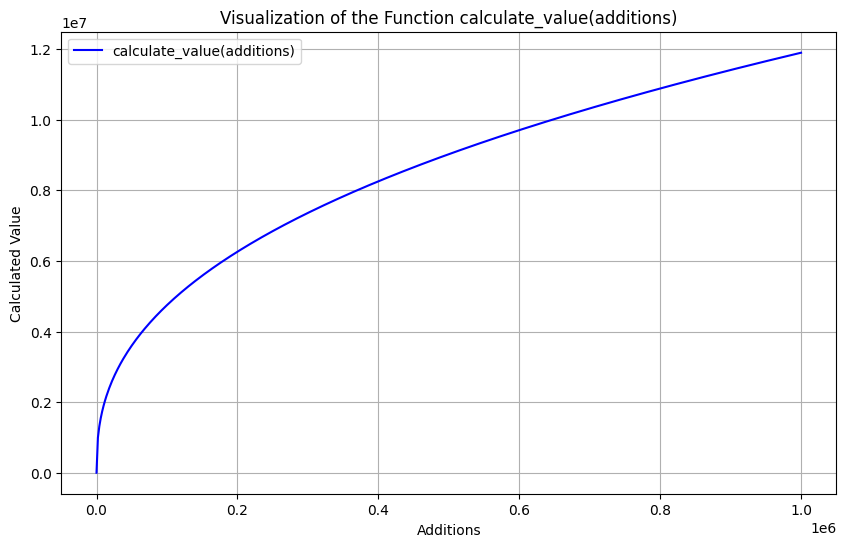

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def calculate_value(additions):
    intermediate_value = additions / 1000
    intermediate_value = intermediate_value ** 1.05
    intermediate_value = intermediate_value * 2.4
    intermediate_value = intermediate_value ** 0.38
    final_value = intermediate_value * 2.5
    personmonths = round(final_value, 5)
    rounded_result = personmonths*216786
    return rounded_result

# Generate a range of addition values
additions_values = np.linspace(0, 1000000, 500)  # from 0 to 10,000 with 500 points

# Calculate the corresponding values
calculated_values = [calculate_value(a) for a in additions_values]

# Plot the function
plt.figure(figsize=(10, 6))
plt.plot(additions_values, calculated_values, label='calculate_value(additions)', color='blue')
plt.xlabel('Additions')
plt.ylabel('Calculated Value')
plt.title('Visualization of the Function calculate_value(additions)')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
def calculate_person_months(additions):
    return round(2.5 * (2.4 * (additions/1000) ** 1.05) ** 0.38, 5)


calculate_person_months(5734819)

110.1716

#### Connected Components Metrics

In [39]:
len(df_sorted['agency'].unique())

18

In [81]:
nx.number_connected_components(G)

233

In [82]:
connected_components = nx.connected_components(G)


In [83]:
component_sizes = [len(component) for component in connected_components]

In [80]:
for component in connected_components:
    print(f"Component: {list(component)}, Size: {len(component)}")

In [84]:
component_sizes

[16116,
 43,
 18,
 4,
 20,
 6,
 3,
 38,
 6,
 3,
 9,
 2,
 2,
 3,
 5,
 3,
 7,
 3,
 10,
 3,
 2,
 2,
 6,
 2,
 2,
 3,
 6,
 7,
 4,
 13,
 6,
 9,
 20,
 8,
 14,
 3,
 5,
 2,
 20,
 7,
 51,
 9,
 4,
 3,
 3,
 7,
 2,
 18,
 4,
 4,
 2,
 2,
 9,
 4,
 4,
 3,
 9,
 8,
 2,
 4,
 7,
 6,
 3,
 5,
 6,
 6,
 11,
 2,
 9,
 4,
 2,
 2,
 2,
 10,
 3,
 2,
 4,
 6,
 6,
 2,
 7,
 4,
 6,
 13,
 3,
 4,
 3,
 5,
 5,
 5,
 5,
 6,
 8,
 2,
 4,
 6,
 2,
 13,
 2,
 2,
 2,
 2,
 15,
 3,
 2,
 4,
 2,
 4,
 3,
 7,
 8,
 2,
 4,
 2,
 2,
 3,
 4,
 7,
 6,
 2,
 2,
 3,
 2,
 3,
 5,
 8,
 3,
 2,
 3,
 8,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 2,
 3,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 3,
 9,
 2,
 3,
 2,
 2,
 3,
 2,
 3,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 8,
 4,
 2,
 3,
 6,
 2,
 3,
 2,
 4,
 2,
 3,
 3,
 2,
 6,
 3,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 6,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 2]

In [86]:
components_check = pd.DataFrame(component_sizes)

In [88]:
components_check.to_csv('component_sizes.csv')

In [42]:
nx.is_connected(G)

False

In [44]:
largest_cc = max(nx.connected_components(G), key=len)

In [45]:
len(largest_cc)

16116

In [46]:
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]

In [47]:
connected_component = list(nx.connected_components(G))

largest_cc = max(nx.connected_components(G), key=len)

largest_cc_subgraph = G.subgraph(largest_cc)

largest_cc_edge_list = list(largest_cc_subgraph.edges())


In [50]:
len(largest_cc_edge_list)

2571191

In [51]:
nx.number_of_nodes(largest_cc_subgraph)

16116

In [53]:
check = nx.nodes(largest_cc_subgraph)

In [54]:
check

NodeView(('0111sandesh', 'SaikrishnaBairamoni', 'Schwartz-Matthew-bah', 'TonyEnglish', 'ToryB1', 'abey-yoseph', 'alexsobledotgov', 'bbrotsos', 'dan-du-car', 'danrasband', 'dependabot[bot]', 'dmccoystephenson', 'drewjj', 'hmusavi', 'iyourshaw', 'jtbaird', 'lauraGgit', 'mgarramo', 'mvs5465', 'payneBrandon', 'snallamothu', 'southernsun', 'tonychen091', 'trevor-trou', '0mp', '12101111', 'AttilaFueloep', 'Avatat', 'BearBabyLiu', 'Blub', 'BrainSlayer', 'BtbN', 'ChaoyuZhang', 'ClashTheBunny', 'ColMelvin', 'ColdCanuck', 'Conan-Kudo', 'CragW', 'CraigLoomis', 'Cyan4973', 'DKOI', 'DeHackEd', 'DimitryAndric', 'Fabian-Gruenbichler', 'Finix1979', 'FireDrunk', 'FransUrbo', 'GarrisonJ', 'GeLiXin', 'Gelma', 'Gerardwx', 'GregorKopka', 'HRio', 'InsanePrawn', 'JKDingwall', 'JMoVS', 'JordanP-Dev', 'Kayvlim', 'KireinaHoro', 'KodyKantor', 'Kream', 'Lalufu', 'Low-power', 'MatMaul', 'Mic92', 'Nasf-Fan', 'Ornias1993', 'PaulZ-98', 'Peter-Levine', 'PeterDaveHello', 'Rabenda', 'RealOrangeOne', 'RichardSharpe', 'Ru

In [68]:
check_df = pd.DataFrame(check, columns=['source', 'target'])

ValueError: Shape of passed values is (16116, 1), indices imply (16116, 2)

In [24]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [26]:
G = nx.Graph()

In [27]:
for _, row in result_df.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['weight'])


In [35]:
nx.number_of_edges(G)

2575859

In [36]:
nx.number_of_nodes(G)

17185

In [21]:
# List of CSV filenames
csv_file = 'department_of_energy_edge.csv'


# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file)

# Create a graph from the DataFrame
G = nx.from_pandas_edgelist(df, source='source', target='target')

In [22]:
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])
nx.approximation.diameter(G0)

10

In [23]:
shortest_path_lengths_G0 = dict(nx.all_pairs_shortest_path_length(G0))

KeyboardInterrupt: 

In [ ]:

average_path_lengths = [np.mean(list(spl.values())) for spl in shortest_path_lengths_G0.values()]

np.mean(average_path_lengths)

### Creating Interagency Edgelist Files for Gizem

In [55]:
 # Query to fetch all records

import pandas as pd
from sqlalchemy.sql import text
sql = '''
    SELECT * FROM inter_agency_edgelist;
'''
with engine.connect().execution_options(autocommit=True) as conn:
    query = conn.execute(text(sql))         
df_inter = pd.DataFrame(query.fetchall())

In [56]:
df_inter

,source_agency,target_agency,weight
0,Department of Energy,GSA,71
1,Department of Homeland Security,GSA,62
2,GSA,HHS,59
3,Department of Energy,NASA,53
4,Department of Energy,Environmental Protection Agency,31
...,...,...,...
110,Education,USDA,1
111,Department of Homeland Security,USDA,1
112,NASA,USDA,1
113,HHS,USDA,1


In [64]:
df_inter.replace("GSA", 
           "General Services Administration", 
           inplace=True)


df_inter.replace("NASA", 
           "National Aeronautics and Space Administration", 
           inplace=True)


df_inter.replace("HHS", 
           "Department of Health & Human Services", 
           inplace=True)

df_inter.replace("Veteran Affairs", 
           "Veterans Affairs", 
           inplace=True)

df_inter.replace("DOD", 
           "Department of Defence", 
           inplace=True)

df_inter.replace("Small Business", 
           "Small Business Administration", 
           inplace=True)

df_inter.replace("Treasury", 
           "Department of the Treasury", 
           inplace=True)

df_inter.replace("Election", 
           "Federal Election Commision", 
           inplace=True)

df_inter.replace("USDA", 
           "Deparment of Agriculture", 
           inplace=True)

df_inter.replace("Transportation", 
           "Department of Transportation", 
           inplace=True)

df_inter.replace("Education", 
           "Department of Education", 
           inplace=True)

df_inter.replace("NSF", 
           "National Science Foundation", 
           inplace=True)

df_inter.replace("SSA", 
           "Social Security Administration", 
           inplace=True)

df_inter.replace("International", 
           "Agency for International Development", 
           inplace=True)

In [65]:
df_inter

,source_agency,target_agency,weight
0,Department of Energy,General Services Administration,71
1,Department of Homeland Security,General Services Administration,62
2,General Services Administration,Department of Health & Human Services,59
3,Department of Energy,National Aeronautics and Space Administration,53
4,Department of Energy,Environmental Protection Agency,31
...,...,...,...
110,Department of Education,Deparment of Agriculture,1
111,Department of Homeland Security,Deparment of Agriculture,1
112,National Aeronautics and Space Administration,Deparment of Agriculture,1
113,Department of Health & Human Services,Deparment of Agriculture,1


In [66]:
df_inter.to_csv('inter_agency_edgelist.csv')